In [27]:
# Import required packages
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from nltk.stem import PorterStemmer 
ps = PorterStemmer() 

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

nltk.download()
# Download window opens, fetch wordnet

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [4]:
# function for text cleaning
def processText(text):
    # From the text remove Backslash and Apostrophe
    text = re.sub("\'", "", text) 
    # From the text remove everything other than alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # From the text remove whitespaces 
    text = ' '.join(text.split()) 
    # Convert the text to lowercase 
    text = text.lower()
    
    # tokenize the text by spliting it into a list
    convText = text.split()
    
    # Perform stemming using the PorterStemmer
    convText = [ps.stem(word) for word in convText]
    
    # Perform lemmatization using the WordNetLemmatizer
    convText = [wordnet_lemmatizer.lemmatize(word) for word in convText]
    
    # Convert the list of words to a single string
    text = ' '.join(convText)
    return text

In [5]:
# Read the preprocessed dataset into the input dataframe
input_df = pd.read_csv("output.csv")
input_df.describe()

,movie_name,genres
count,199280,199280
unique,173598,1270
top,Broken,['drama']
freq,27,31490


In [6]:
# Check if the dataset which has been read is correct by reading the first five rows
input_df.head()


,movie_name,genres
0,Miss Jerry,['romance']
1,Hamlet,['drama']
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']"
3,"Hamlet, Prince of Denmark",['drama']
4,The Life of Moses,"['biography', 'drama', 'family']"


In [7]:
# As the type of genres is a string we need to convert it to list structure
print(type(input_df['genres'][0]))

<class 'str'>


In [8]:
# Convert string to list
# Also populate an array to have all the genres in the dataset to visualize 
totalGenres = []
allGenres = []
for row in input_df['genres']:
    if row:
        temp = []
        #Remove the 
        curstr = row[1:-1]
        curGenres = curstr.split(',')
        for eachGenre in curGenres:
            allGenres.append(eachGenre.strip())
            temp.append(eachGenre.strip())
        totalGenres.append(temp)

input_df['new_genres'] = totalGenres

input_df


,movie_name,genres,new_genres
0,Miss Jerry,['romance'],['romance']
1,Hamlet,['drama'],['drama']
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","['adventure', 'fantasy']"
3,"Hamlet, Prince of Denmark",['drama'],['drama']
4,The Life of Moses,"['biography', 'drama', 'family']","['biography', 'drama', 'family']"
...,...,...,...
199275,Liebestraum,['musical'],['musical']
199276,The unknown project title at this time,['comedy'],['comedy']
199277,Minotaur,['thriller'],['thriller']
199278,Coven,"['drama', 'history', 'horror']","['drama', 'history', 'horror']"


In [9]:
# Remove the rows where there are not genres as they don't provide any value to our analysis
input_df_new = input_df[~(input_df['new_genres'].str.len() == 0)]
input_df

,movie_name,genres,new_genres
0,Miss Jerry,['romance'],['romance']
1,Hamlet,['drama'],['drama']
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","['adventure', 'fantasy']"
3,"Hamlet, Prince of Denmark",['drama'],['drama']
4,The Life of Moses,"['biography', 'drama', 'family']","['biography', 'drama', 'family']"
...,...,...,...
199275,Liebestraum,['musical'],['musical']
199276,The unknown project title at this time,['comedy'],['comedy']
199277,Minotaur,['thriller'],['thriller']
199278,Coven,"['drama', 'history', 'horror']","['drama', 'history', 'horror']"


In [10]:
input_df_new.describe()

,movie_name,genres,new_genres
count,199280,199280,199280
unique,173598,1270,1270
top,Broken,['drama'],['drama']
freq,27,31490,31490


In [11]:
# Use the inbuilt nltk package to get the number of times a genre has occured in the dataset
allGenres = nltk.FreqDist(allGenres) 

In [12]:
# Conver to a dataframe
all_genres_df = pd.DataFrame({'Genre': list(allGenres.keys()), 
                              'Count': list(allGenres.values())})

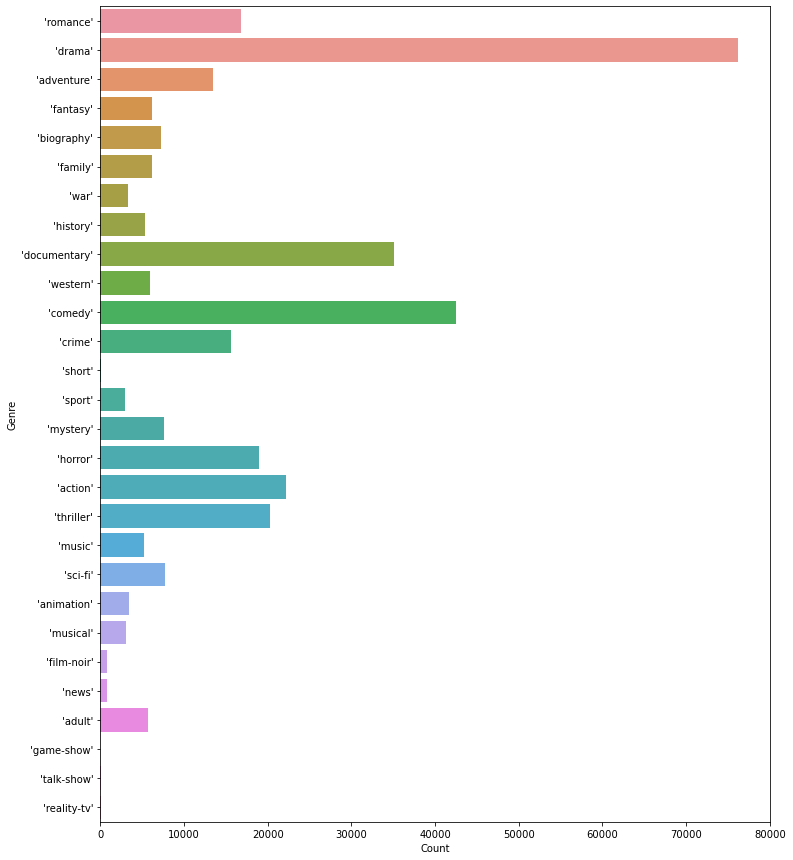

In [13]:
# Visualize genres 
plt.figure(figsize=(12,15)) 
axis = sns.barplot(data=all_genres_df, x= "Count", y = "Genre") 
axis.set(ylabel = 'Genre') 
plt.show()

In [14]:
# Clean the movie title by using the processing function
input_df['movie_name_clean'] = input_df['movie_name'].apply(lambda x: processText(x))

In [15]:
#Snapshot of the new dataset
input_df.head()

,movie_name,genres,new_genres,movie_name_clean
0,Miss Jerry,['romance'],['romance'],miss jerri
1,Hamlet,['drama'],['drama'],hamlet
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","['adventure', 'fantasy']",the fairylogu and radio play
3,"Hamlet, Prince of Denmark",['drama'],['drama'],hamlet princ of denmark
4,The Life of Moses,"['biography', 'drama', 'family']","['biography', 'drama', 'family']",the life of mose


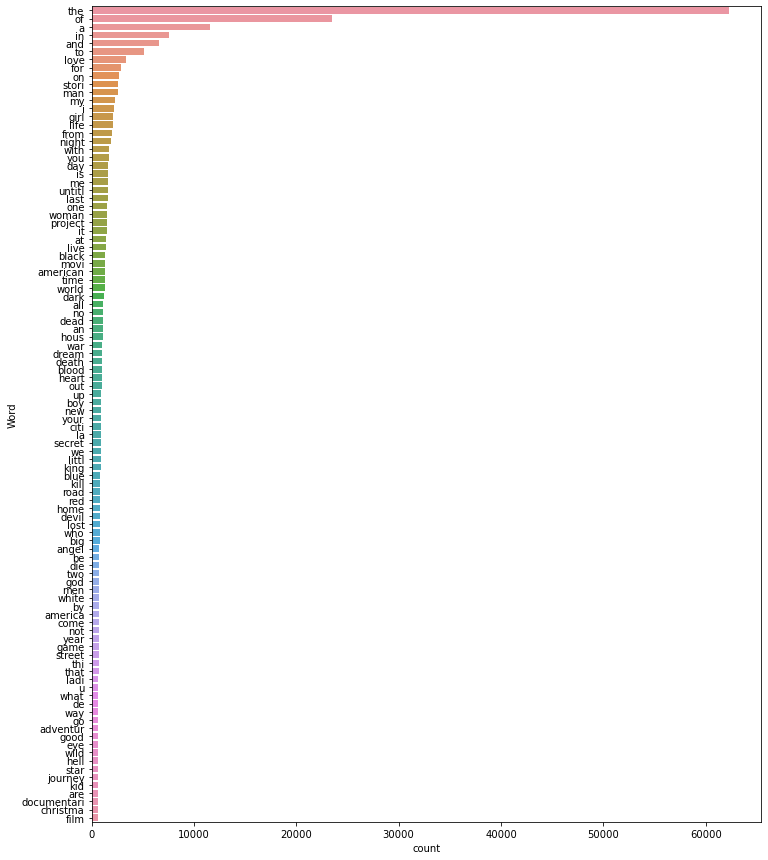

In [16]:
def freq_words(x, terms = 30): 
  totalWords = ' '.join([text for text in x]) 
  totalWords = totalWords.split() 
  wordFrequency = nltk.FreqDist(totalWords) 
  words_df = pd.DataFrame({'word':list(wordFrequency.keys()), 'count':list(wordFrequency.values())}) 
  
  # Select the top words 
  topWords = words_df.nlargest(columns="count", n = terms) 
  
  # Visualize the data 
  plt.figure(figsize=(12,15)) 
  axis = sns.barplot(data=topWords, x= "count", y = "word") 
  axis.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(input_df['movie_name_clean'], 100)

In [17]:
# Remove stopwords
def removeSW(text):
    convText = [w for w in text.split() if not w in stop_words]
    return ' '.join(convText)

input_df['movie_name_clean'] = input_df['movie_name_clean'].apply(lambda t: removeSW(t))

In [18]:
# Function to generate world cloud 
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");

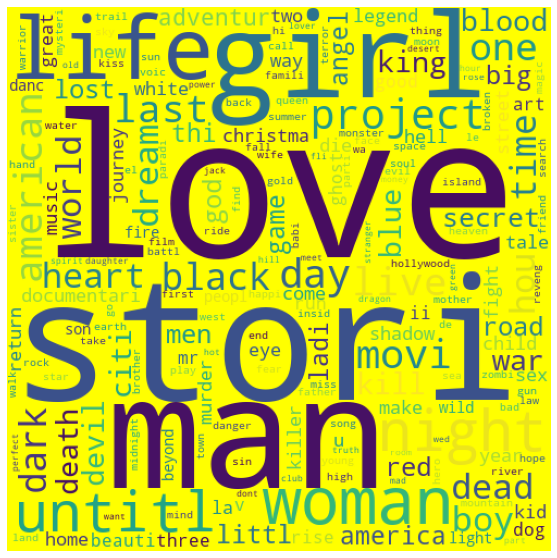

In [19]:
# Generate a word cloud to visualize the top words after removing stop words
all_words = ' '.join([text for text in input_df['movie_name_clean']]) 
wordcloud = WordCloud(width = 500, height = 500, background_color='yellow', random_state=10).generate(all_words)
plot_cloud(wordcloud)

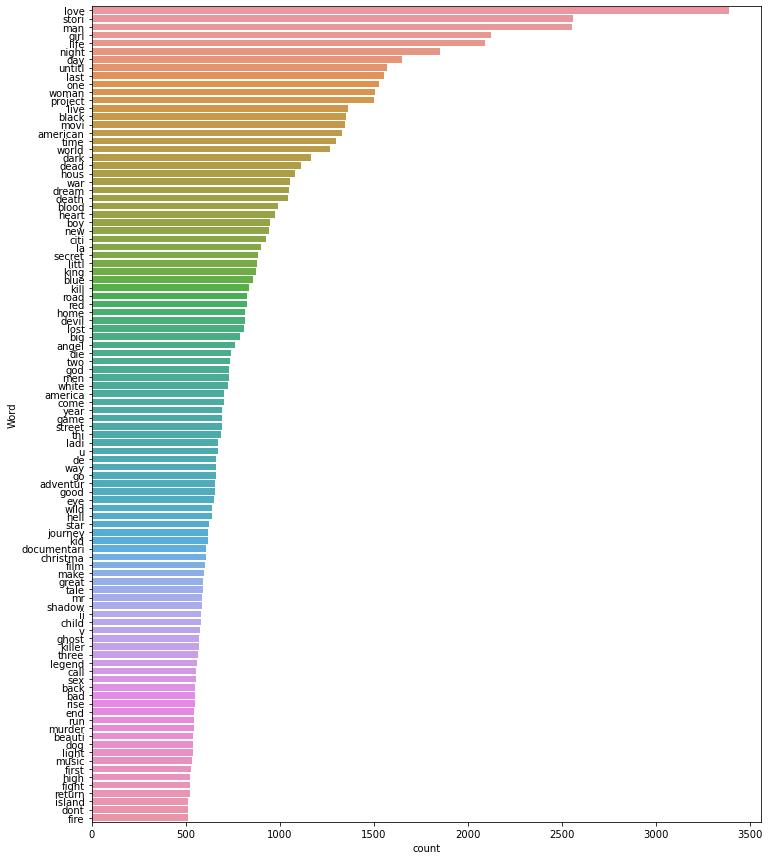

In [20]:
# Generate a bar plot for the cleaned movie title column after removing the stopwords
freq_words(input_df['movie_name_clean'], 100)

In [21]:
# One-hot encoding the genres column
multilabelBinarizer = MultiLabelBinarizer()
multilabelBinarizer.fit(input_df['new_genres'])

y = multilabelBinarizer.transform(input_df['new_genres'])

In [22]:
# Use the TFIDF method to generate the vectors
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=100000)

In [23]:
# Split the data into training and test set. We are using the 
xtrain, xval, ytrain, yval = train_test_split(input_df['movie_name_clean'], y, test_size=0.1)


In [24]:
# Transform the movie title to vectors using the TFIDF methods
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [30]:
# Use a logistic regression method to train the model
lr = LogisticRegression(max_iter=10000)
clf = OneVsRestClassifier(lr)

In [31]:
# Using a 5-fold Cross Validation on training data
# cross_val_score(clf, xtrain, ytrain, cv=5)

In [32]:
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000))

In [73]:
# Predict the values for the testing set using the LR model
y_pred = clf.predict(xval_tfidf)

In [79]:
# Get the predicted value which has an index 4
multilabelBinarizer.inverse_transform(y_pred)[11]


("'drama'",)

In [80]:
# Generate the F1 score for the model
f1_score(yval, y_pred, average="micro")

0.1897594879743987

In [82]:
f1_score(yval, y_pred, average="weighted")

0.16941712951001087

In [83]:
# Since logistic regression always uses 0.5 as treshold we can check by changing 
# the treshold value and check if it improves our score
y_pred_prob = clf.predict_proba(xval_tfidf)

In [84]:
t = 0.3 
y_pred_new = (y_pred_prob >= t).astype(int)

In [85]:
f1_score(yval, y_pred_new, average="micro")

0.38839497794367156

In [86]:
def testPrediction(movieTitle):
    movieTitle = processText(movieTitle)
    movieTitle = removeSW(movieTitle)
    movieTitleVec = tfidf_vectorizer.transform([movieTitle])
    testPred = clf.predict(movieTitleVec)
    return multilabelBinarizer.inverse_transform(testPred)

In [94]:
for i in range(5):
    k = xval.sample(1).index[0]
    print("Movie Title: ", input_df['movie_name'][k], "\nPredicted genre: ", testPrediction(xval[k])), print("Actual genre: ",input_df['new_genres'][k], "\n")


Movie Title:  Night Cargo 
Predicted genre:  [("'drama'",)]
Actual genre:  ["'crime'", "'drama'"] 

Movie Title:  The Galaxy Railways part 2: The Alfert Threat 
Predicted genre:  [()]
Actual genre:  ["'sci-fi'"] 

Movie Title:  High School Cheer 
Predicted genre:  [("'comedy'",)]
Actual genre:  ["'comedy'"] 

Movie Title:  Whaling City 
Predicted genre:  [("'drama'",)]
Actual genre:  ["'drama'"] 

Movie Title:  Shuddh Desi Romance 
Predicted genre:  [("'comedy'", "'drama'")]
Actual genre:  ["'drama'", "'romance'"] 



In [91]:

print(metrics.classification_report(yval, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.06      0.10      2163
           1       0.78      0.07      0.12       590
           2       0.67      0.04      0.08      1427
           3       1.00      0.01      0.01       358
           4       0.25      0.00      0.00       728
           5       0.56      0.10      0.17      4337
           6       0.45      0.02      0.04      1531
           7       0.68      0.15      0.25      3416
           8       0.54      0.27      0.36      7569
           9       0.50      0.02      0.04       577
          10       0.50      0.00      0.01       655
          11       0.00      0.00      0.00        72
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00       534
          14       0.64      0.17      0.27      1939
          15       0.30      0.01      0.01       498
          16       0.50      0.01      0.02       328
          17       0.38    